# Analysis on CDKN2A Gene Therapy

Presented By:QANY



**Import datas and necessary library**

In [3]:
import pandas as pd
import re
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from ipywidgets import interact, IntSlider
import time
from IPython.display import clear_output
import ipywidgets as widgets
import networkx as nx

articles = pd.read_csv("articles.CDKN2A.csv")
authors = pd.read_csv("authors.CDKN2A.csv")
paper = pd.read_csv("paper_counts.csv")


**Top researchers who were actively working the last 5 years**

**Cooperative and competitive relationships between active researchers.**

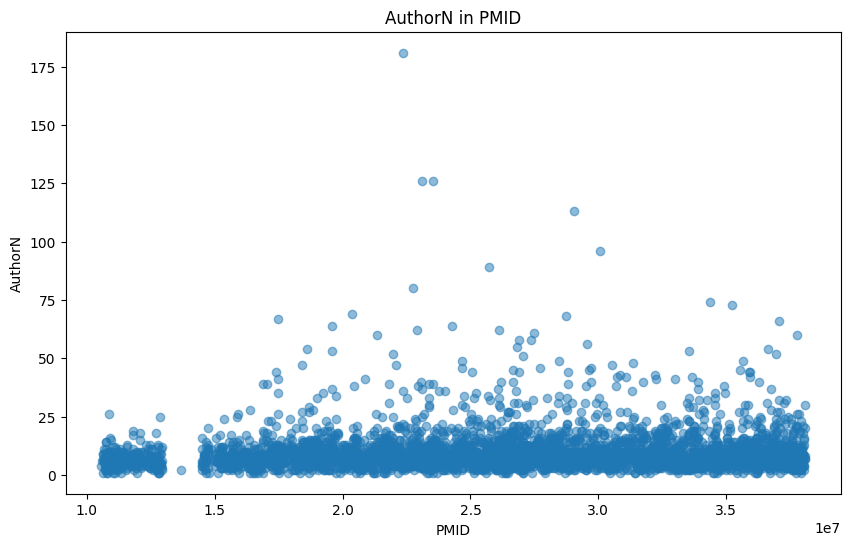

<ipython-input-4-7afa2e58604c>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_authors_data['Author Full Name'] =cleaned_authors_data['AuthorForename'] + ' ' + cleaned_authors_data['AuthorLastname']
<ipython-input-4-7afa2e58604c>:69: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  common_last_authors = set(last_authors[papers_author1]) & set(last_authors[papers_author2])
<ipython-input-4-7afa2e58604c>:69: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  common_last_authors = set(last_authors[papers_author1]) & set(last_authors[papers_author2])
<ipython-input-4-7afa2e58604c>:69: FutureWarning: Passing a set

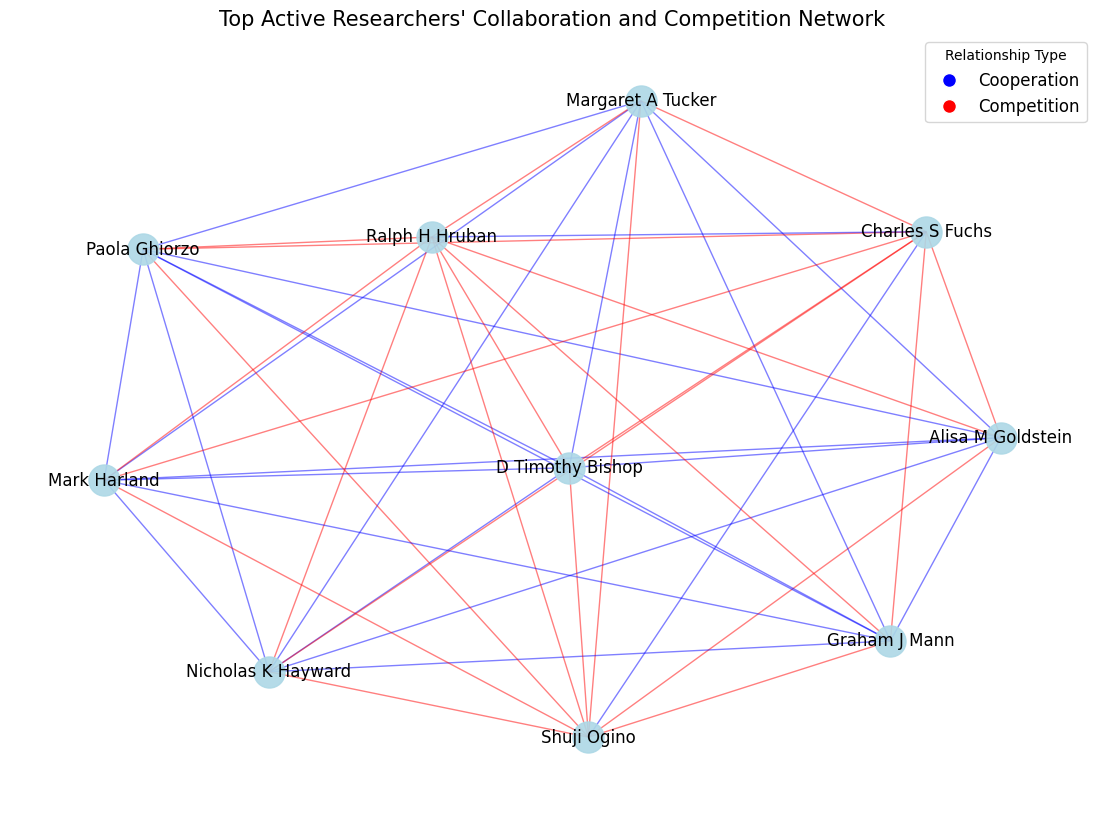

In [4]:
#cleaning data


#scatter to show the author number
result = authors.groupby('PMID')['AuthorN'].agg('max')
result_data = result.reset_index()
#Make scatter plots
x = result_data['PMID']
y = result_data['AuthorN']
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.5)
plt.title('AuthorN in PMID')
plt.xlabel('PMID')
plt.ylabel('AuthorN')
plt.show()

# Calculate the number of authors per article (PMID)
author_counts_per_paper = authors.groupby('PMID').size()

# Find the PMID of articles with more than 25 authors
papers_with_many_authors = author_counts_per_paper[author_counts_per_paper > 25].index

# Clear from the data
cleaned_authors_data = authors[~authors['PMID'].isin(papers_with_many_authors)]

# Check the maximum AuthorN value in the cleared data
max_author_n_after_cleaning = cleaned_authors_data['AuthorN'].max()

cleaned_authors_data['Author Full Name'] =cleaned_authors_data['AuthorForename'] + ' ' + cleaned_authors_data['AuthorLastname']


#Make the relationship network
authors['Author Full Name'] = authors['AuthorForename'] + ' ' + authors['AuthorLastname']

# Count the number of times all authors appear
all_author_counts = authors['Author Full Name'].value_counts()

# Get the top 10 most active researchers
top_10_active_researchers = all_author_counts.head(10).index.tolist()

# Sift through the data for the top 10 most active researchers
top_authors_df = cleaned_authors_data[cleaned_authors_data['Author Full Name'].isin(top_10_active_researchers)]

# Create a new diagram
G_top = nx.Graph()

# Add node
G_top.add_nodes_from(top_10_active_researchers)

# Add a partnership edge
for _, group in top_authors_df.groupby('PMID'):
    authors = group['Author Full Name'].tolist()
    for i in range(len(authors)):
        for j in range(i + 1, len(authors)):
            G_top.add_edge(authors[i], authors[j], color='blue')  # 合作关系

# Identify the last author
last_authors = cleaned_authors_data.groupby('PMID').last()['Author Full Name']

# Adds a competitive edge
for i in range(len(top_10_active_researchers)):
    for j in range(i + 1, len(top_10_active_researchers)):
        author1 = top_10_active_researchers[i]
        author2 = top_10_active_researchers[j]
        if not G_top.has_edge(author1, author2):
            papers_author1 = set(cleaned_authors_data[cleaned_authors_data['Author Full Name'] == author1]['PMID'])
            papers_author2 = set(cleaned_authors_data[cleaned_authors_data['Author Full Name'] == author2]['PMID'])
            # uses the intersection operator & to determine if there is a common last author
            common_last_authors = set(last_authors[papers_author1]) & set(last_authors[papers_author2])
            if not common_last_authors:
                G_top.add_edge(author1, author2, color='red')


# Visual network diagram
edge_colors = nx.get_edge_attributes(G_top, 'color').values()

plt.figure(figsize=(14, 10))
# Use spring layout
pos = nx.spring_layout(G_top)
nx.draw_networkx_nodes(G_top, pos, node_color='lightblue', node_size=500, alpha=0.9)
nx.draw_networkx_edges(G_top, pos, edge_color=edge_colors, alpha=0.5)
nx.draw_networkx_labels(G_top, pos, font_size=12, font_family="sans-serif")
legend_labels = {'Cooperation': 'blue', 'Competition': 'red'}
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=key, markersize=10, markerfacecolor=value) for key, value in legend_labels.items()]
plt.legend(handles=legend_handles, title='Relationship Type', loc='upper right', fontsize=12)
plt.title("Top Active Researchers' Collaboration and Competition Network", fontsize=15)
plt.axis('off')
plt.show()


**Number of CDKN2A papers and percentage in PubMed.**

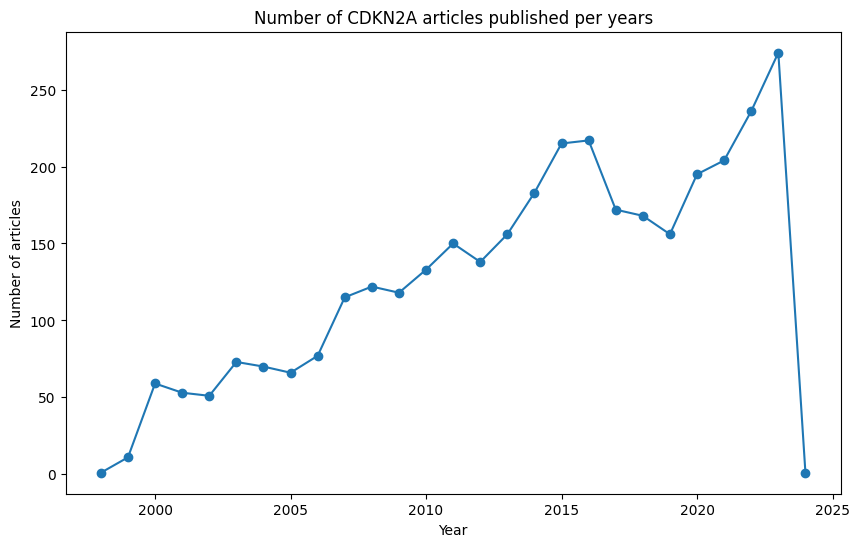

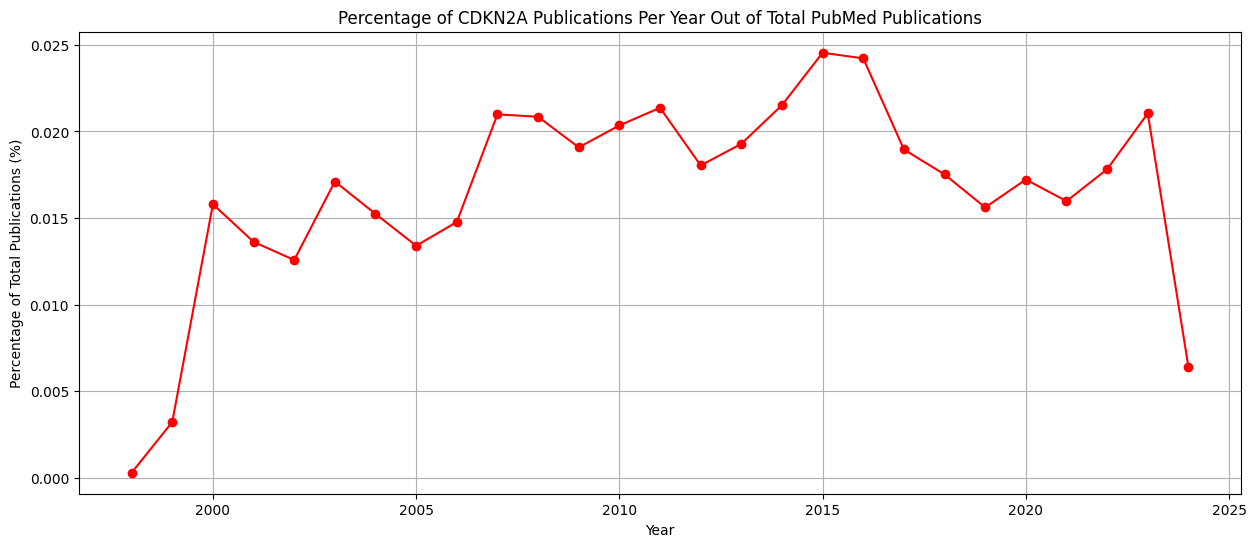

In [6]:
#Number of CDKN2A papers
articles_counts = articles['Year'].value_counts().sort_index()

plt.figure(figsize=(10,6))
plt.plot(articles_counts.index,articles_counts.values, marker = 'o')
plt.xlabel("Year")
plt.ylabel("Number of articles")
plt.title("Number of CDKN2A articles published per years")

#Percentage in PubMed

# Rename the column in paper_counts_data for clarity
paper.rename(columns={'Count': 'TotalPapers'}, inplace=True)

# Count the number of CDKN2A articles per year
CDKN2A = articles.groupby('Year').size().reset_index(name='CDKN2ACount')

# Merge the CDKN2A per year with total paper counts per year
merged_data = pd.merge(CDKN2A, paper, on='Year')

# Calculate the percentage of CDKN2A publications out of total publications per year
merged_data['CDKN2APercentage'] = (merged_data['CDKN2ACount'] / merged_data['TotalPapers']) * 100

# Plotting the percentage trend
plt.figure(figsize=(15, 6))
plt.plot(merged_data['Year'], merged_data['CDKN2APercentage'], marker='o', color='red')
plt.title('Percentage of CDKN2A Publications Per Year Out of Total PubMed Publications')
plt.xlabel('Year')
plt.ylabel('Percentage of Total Publications (%)')
plt.grid(True)
plt.show()

**Display the number of journals based on the first author and publication count.**

**Visualization of the number of authors and article regions.**

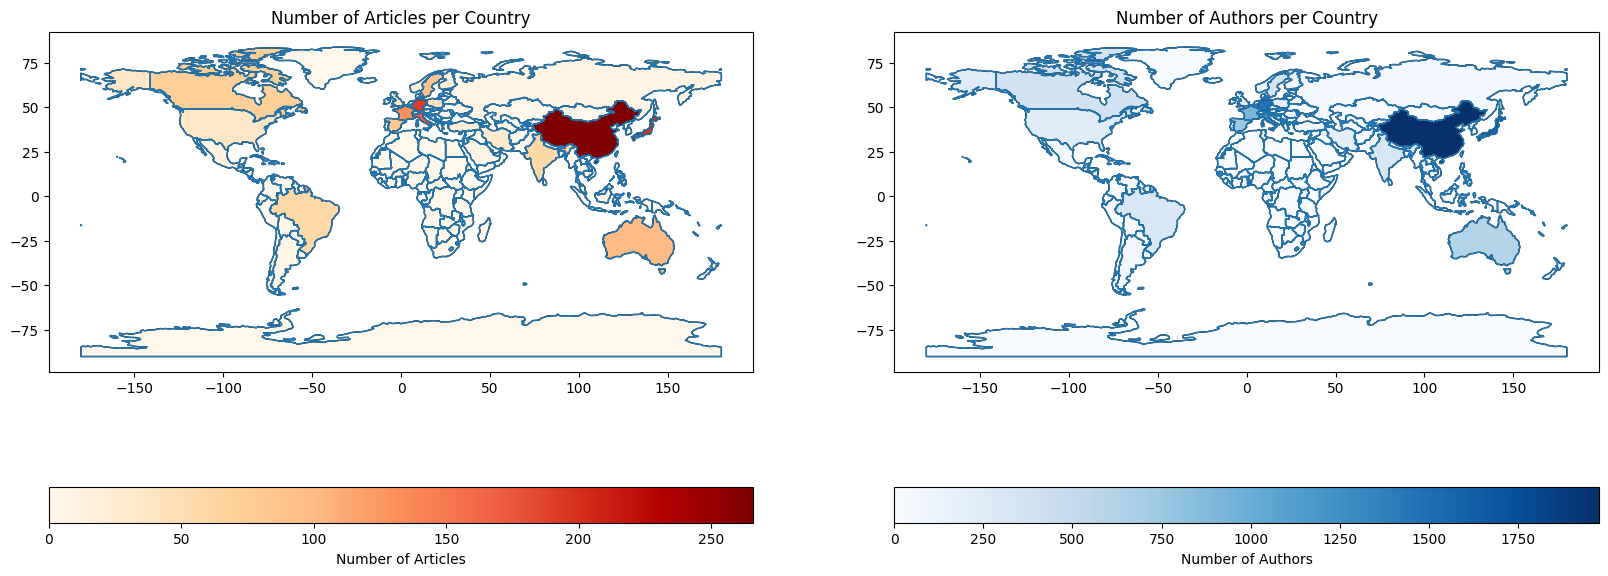

In [ ]:
def extract_country(affiliation):
    """
    从作者单位信息中提取国家名。
    """
    if pd.isna(affiliation):
        return "Unknown"
    try:
        country = affiliation.split(',')[-1].strip()
        country = re.sub(r"(University|Institute|Hospital|Department|College|School).*$", "", country).strip()
        return country
    except:
        return "Unknown"

def clean_country_name(country):
    """
    清理提取出的国家名。
    """
    country = re.sub(r"\..*|\s\-\s.*", "", country)
    return country

# 应用函数到相关列
articles['articles_country'] = articles['FirstAuthorAffiliation'].apply(extract_country).apply(clean_country_name)
authors['authors_country'] = authors['AuthorAffiliation'].apply(extract_country).apply(clean_country_name)

# 按国家分组并计算文章和作者的数量
articles_count = articles['articles_country'].value_counts().reset_index()
articles_count.columns = ['Country', 'ArticleCount']

authors_count = authors['authors_country'].value_counts().reset_index()
authors_count.columns = ['Country', 'AuthorCount']

# 使用 geopandas 读取下载的 .shp 文件
world = gpd.read_file('mapdata/ne_110m_admin_0_countries.shp')

# 将计数与世界地图数据合并
world = world.merge(articles_count, left_on='ADMIN', right_on='Country', how='left')
world = world.merge(authors_count, left_on='ADMIN', right_on='Country', how='left')

# 用0填充NaN值
world['ArticleCount'] = world['ArticleCount'].fillna(0)
world['AuthorCount'] = world['AuthorCount'].fillna(0)

# 绘制地图：文章数量和作者数量
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# 文章数量地图
world.boundary.plot(ax=ax[0], linewidth=1)
world.plot(column='ArticleCount', ax=ax[0], legend=True,
           legend_kwds={'label': "Number of Articles", 'orientation': "horizontal"},
           cmap='OrRd', edgecolor='black')
ax[0].set_title('Number of Articles per Country')

# 作者数量地图
world.boundary.plot(ax=ax[1], linewidth=1)
world.plot(column='AuthorCount', ax=ax[1], legend=True,
           legend_kwds={'label': "Number of Authors", 'orientation': "horizontal"},
           cmap='Blues', edgecolor='black')
ax[1].set_title('Number of Authors per Country')

plt.show()

**Visualization of the review papers**